In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

In [81]:
pip install xgboost


     -------------------------------------- 124.9/124.9 MB 1.6 MB/s eta 0:00:00


## Importing updated train data based on Data cleansing

In [14]:
sales_data = pd.read_csv('updated_train.csv')

In [15]:
sales_data.head()

,Unnamed: 0,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,item_count
0,0,FDA15,9.30,low fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,14.951963
1,1,DRC01,5.92,regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,9.186454
2,2,FDN15,17.50,low fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,14.809346
3,6,FDO10,13.65,regular,0.012741,Snack Foods,57.6588,OUT013,1987,High,Tier 3,Supermarket Type1,343.5528,5.958376
4,7,FDP10,19.00,low fat,0.127470,Snack Foods,107.7622,OUT027,1985,Medium,Tier 3,Supermarket Type3,4022.7636,37.330006


## Data Transformation and Feature Engineering

In [16]:
# Encoding Ordinal variables through Label Encoding 
Item_Fat_Content_encoder = OrdinalEncoder(categories=[['low fat','regular']])
Outlet_Size_encoder = OrdinalEncoder(categories=[['Small','Medium','High']])
Outlet_Location_Type_encoder = OrdinalEncoder(categories=[['Tier 3','Tier 2','Tier 1']])
Outlet_Type_encoder = OrdinalEncoder(categories=[['Grocery Store','Supermarket Type3','Supermarket Type2','Supermarket Type1']])

sales_data['Item_Fat_Content_Encoded'] = Item_Fat_Content_encoder.fit_transform(sales_data[['Item_Fat_Content']])
sales_data['Outlet_Size_Encoded'] = Outlet_Size_encoder.fit_transform(sales_data[['Outlet_Size']])
sales_data['Outlet_Location_Type_Encoded'] = Outlet_Location_Type_encoder.fit_transform(sales_data[['Outlet_Location_Type']])
sales_data['Outlet_Type_Encoded'] = Outlet_Type_encoder.fit_transform(sales_data[['Outlet_Type']])

# Encoding Nominal variables through One Hot Encoding
encoder = OneHotEncoder(sparse_output=False)
Item_Type_encoded_array = encoder.fit_transform(sales_data[['Item_Type']])
Item_Type_encoded = pd.DataFrame(Item_Type_encoded_array, columns=encoder.get_feature_names_out(['Item_Type']))
sales_data_updated = pd.concat([sales_data,Item_Type_encoded],axis=1)

# Transforming Outlet Establishment Year to Years since Established
sales_data_updated['Year_since_estblished'] = 2013 - sales_data_updated['Outlet_Establishment_Year']

In [25]:
sales_data_updated.columns

Index(['Unnamed: 0', 'Item_Identifier', 'Item_Weight', 'Item_Fat_Content',
       'Item_Visibility', 'Item_Type', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type', 'Item_Outlet_Sales', 'item_count',
       'Item_Fat_Content_Encoded', 'Outlet_Size_Encoded',
       'Outlet_Location_Type_Encoded', 'Outlet_Type_Encoded',
       'Item_Type_Baking Goods', 'Item_Type_Breads', 'Item_Type_Breakfast',
       'Item_Type_Canned', 'Item_Type_Dairy', 'Item_Type_Frozen Foods',
       'Item_Type_Fruits and Vegetables', 'Item_Type_Hard Drinks',
       'Item_Type_Health and Hygiene', 'Item_Type_Household', 'Item_Type_Meat',
       'Item_Type_Others', 'Item_Type_Seafood', 'Item_Type_Snack Foods',
       'Item_Type_Soft Drinks', 'Item_Type_Starchy Foods',
       'Year_since_estblished'],
      dtype='object')

## Preparing Data for Model Fitting

In [441]:
final_columns = ['Item_Weight','Item_Fat_Content_Encoded',
       'Item_Visibility', 'Item_MRP',
       'Item_Type_Baking Goods', 'Item_Type_Breads', 'Item_Type_Breakfast',
       'Item_Type_Canned', 'Item_Type_Dairy', 'Item_Type_Frozen Foods',
       'Item_Type_Fruits and Vegetables', 'Item_Type_Hard Drinks',
       'Item_Type_Health and Hygiene', 'Item_Type_Household', 'Item_Type_Meat', 'Item_Type_Seafood', 'Item_Type_Snack Foods',
       'Item_Type_Soft Drinks', 'Item_Type_Starchy Foods', 'Outlet_Size_Encoded',
       'Outlet_Location_Type_Encoded', 'Outlet_Type_Encoded','Year_since_estblished','Item_Outlet_Sales']

final_features=final_columns[:-1]
final_data = sales_data_updated[final_columns]

## Keeping 5% of the data for Out of Sample Testing 
oos_data = final_data.sample(frac=0.05, random_state=42)
model_building_data = final_data[~final_data.index.isin(oos_data.index)]

target_var = 'Item_Outlet_Sales'
X = model_building_data[final_features]
y = model_building_data[target_var]
oos_X = oos_data[final_features]
oos_y = oos_data[target_var]

## Splitting Test and Train Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Decision Tree Regressor

In [443]:
dt_regressor = DecisionTreeRegressor(max_depth=5, random_state=42)
dt_regressor.fit(X_train, y_train)

#Predicting for validation set and calculating rmse and Rsqured values
y_pred = dt_regressor.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
print("RMSE:",rmse," R-Squared value:", r2)

RMSE: 1111.9542122238922  R-Squared value: 0.5730266007878043


In [444]:
#Fitting Grid Search for finding best parameters

param_grid = {
    'max_depth': [3, 5, 10, None],  
    'min_samples_split': [2, 5, 10],  
    'min_samples_leaf': [1, 2, 4], 
    'criterion': ['squared_error', 'friedman_mse', 'absolute_error'] 
}
grid_search = GridSearchCV(
    estimator=dt_regressor, 
    param_grid=param_grid, 
    cv=5,  
    scoring='neg_mean_squared_error',  
    n_jobs=-1,  
    verbose=1 
)

grid_search.fit(X_train, y_train)

# Best parameters from Grid Search
print("Best Parameters:", grid_search.best_params_)


# Retraining Model based on best parameters from Grid Search
dt_regressor = DecisionTreeRegressor(max_depth=grid_search.best_params_['max_depth'],min_samples_leaf=grid_search.best_params_['min_samples_leaf'],min_samples_split=grid_search.best_params_['min_samples_split'],criterion=grid_search.best_params_['criterion'], random_state=42)
dt_regressor.fit(X_train, y_train)

#Predicting for validation set and calculating rmse and Rsqured values
y_pred = dt_regressor.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
print("Validation Set - ","RMSE:",rmse," R-Squared value:", r2)

#Predicting for OOS set and calculating rmse and Rsqured values
y_pred = dt_regressor.predict(oos_X)
mae = mean_absolute_error(oos_y, y_pred)
mse = mean_squared_error(oos_y, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(oos_y, y_pred)
print("Test Set - ""RMSE:",rmse," R-Squared value:", r2)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters: {'criterion': 'squared_error', 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 10}
Validation Set -  RMSE: 1111.9102075902517  R-Squared value: 0.5730603943307839
Test Set - RMSE: 1077.9679316021918  R-Squared value: 0.6252271246504879


## Random Forest Regressor

In [445]:
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train, y_train)

#Predicting for validation set and calculating rmse and Rsqured values
y_pred = rf_regressor.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
print("RMSE:",rmse," R-Squared value:", r2)

RMSE: 1184.7174420433162  R-Squared value: 0.5153183528633039


In [446]:
#Fitting Grid Search for finding best parameters
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(estimator=rf_regressor, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Best parameters
print(f"Best Parameters: {grid_search.best_params_}")

# Retraining Model based on best parameters from Grid Search
rf_regressor = RandomForestRegressor(n_estimators=grid_search.best_params_['n_estimators'],max_depth= grid_search.best_params_['max_depth'],min_samples_split=grid_search.best_params_['min_samples_split'], random_state=42)
rf_regressor.fit(X_train, y_train)

#Predicting for validation set and calculating rmse and Rsqured values
y_pred = rf_regressor.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
print("Validation Set - ","RMSE:",rmse," R-Squared value:", r2)

#Predicting for OOS set and calculating rmse and Rsqured values
y_pred = rf_regressor.predict(oos_X)
mae = mean_absolute_error(oos_y, y_pred)
mse = mean_squared_error(oos_y, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(oos_y, y_pred)
print("Test Set - ""RMSE:",rmse," R-Squared value:", r2)

Best Parameters: {'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 200}
Validation Set -  RMSE: 1107.2569901299844  R-Squared value: 0.5766263043785003
Test Set - RMSE: 1081.270497678254  R-Squared value: 0.6229272266016286


## XG Boost Regressor

In [447]:
xgb_regressor = XGBRegressor(n_estimators=100, random_state=42)
xgb_regressor.fit(X_train, y_train)

#Predicting for validation set and calculating rmse and Rsqured values
y_pred = xgb_regressor.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
rmse, r2

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

# Perform grid search
grid_search = GridSearchCV(estimator=XGBRegressor(), param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Best parameters
print(f"Best Parameters: {grid_search.best_params_}")

# Retraining Model based on best parameters from Grid Search
xgb_regressor = XGBRegressor(n_estimators=grid_search.best_params_['n_estimators'],max_depth= grid_search.best_params_['max_depth'],learning_rate= grid_search.best_params_['learning_rate'], random_state=42)
xgb_regressor.fit(X_train, y_train)

#Predicting for validation set and calculating rmse and Rsqured values
y_pred = xgb_regressor.predict(X_test)
xgb_regressor.fit(X_train, y_train)
y_pred = xgb_regressor.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
print("Validation Set - ","RMSE:",rmse," R-Squared value:", r2)

#Predicting for OOS set and calculating rmse and Rsqured values
y_pred = xgb_regressor.predict(oos_X)
mae = mean_absolute_error(oos_y, y_pred)
mse = mean_squared_error(oos_y, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(oos_y, y_pred)
print("Test Set - ""RMSE:",rmse," R-Squared value:", r2)

Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Validation Set -  RMSE: 1104.142984911793  R-Squared value: 0.5790043142144865
Test Set - RMSE: 1076.924090089692  R-Squared value: 0.6259525897858098


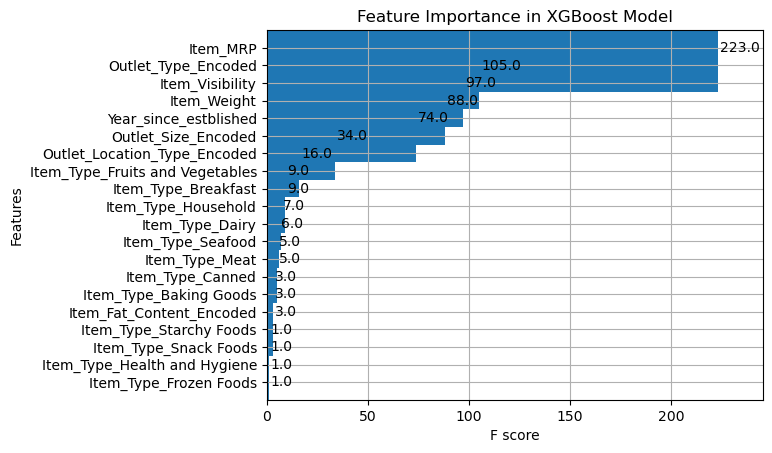

In [235]:
xgb.plot_importance(xgb_regressor, importance_type='weight', max_num_features=20,height=5)
plt.title('Feature Importance in XGBoost Model')
plt.show()

## Generating Submission Data for hackathon

In [451]:
#importing Test Data
sales_df = pd.read_csv('test_AbJTz2l.csv')

In [456]:
#Standardising values for Fat Content
sales_df.loc[sales_df.Item_Fat_Content == 'LF', 'Item_Fat_Content'] = 'Low Fat'
sales_df.loc[sales_df.Item_Fat_Content == 'reg', 'Item_Fat_Content'] = 'Regular'
sales_df['Item_Fat_Content'] =sales_df['Item_Fat_Content'].str.lower()

#Missing Value treatment for Item Weight
mis_weight = sales_df[sales_df.Item_Weight.isnull()]['Item_Identifier'].unique()
mis_weight2= sales_df.loc[sales_df.Item_Identifier.isin(mis_weight),['Item_Identifier','Item_Weight']].groupby('Item_Identifier')['Item_Weight'].agg(['min','max']).reset_index()
mis_weight2.columns= ['Item_Identifier','minval','maxval']
mis_weight2.set_index('Item_Identifier', inplace=True)
mis_weight_type1= mis_weight2[~mis_weight2.minval.isnull()]
mis_weight_type1
mis_weight_type1_map = mis_weight_type1.loc[:,'minval'].T.to_dict()

#The missing values for item weight in particular records cn be replaced by the min/max values for the corresponding item id in the entire dataset  
sales_df.loc[sales_df.Item_Weight.isnull(),'Item_Weight'] = sales_df.loc[sales_df.Item_Weight.isnull(),'Item_Identifier'].map(mis_weight_type1_map)

#Remaining missing values can be imputed from the mapping created from training data 
weight_map = sales_data.loc[:,['Item_Identifier','Item_Weight']].drop_duplicates().set_index('Item_Identifier').loc[:,'Item_Weight'].T.to_dict()
sales_df.loc[sales_df.Item_Weight.isnull(),'Item_Weight'] = sales_df.loc[sales_df.Item_Weight.isnull(),'Item_Identifier'].map(weight_map)

#Ensuring no missing values in item weight
print(sales_df[sales_df.Item_Weight.isnull()].Item_Weight.count())

#Missing values for Outlet Identifier can be imputed from the mapping created from training data 
osize_map = sales_data.loc[:,['Outlet_Identifier','Outlet_Size']].drop_duplicates().set_index('Outlet_Identifier').loc[:,'Outlet_Size'].T.to_dict()
sales_df.loc[sales_df.Outlet_Size.isnull(),'Outlet_Size'] = sales_df.loc[sales_df.Outlet_Size.isnull(),'Outlet_Identifier'].map(osize_map)

# Encoding ordinal variables through Label Encoding
sales_df['Item_Fat_Content_Encoded'] = Item_Fat_Content_encoder.fit_transform(sales_df[['Item_Fat_Content']])
sales_df['Outlet_Size_Encoded'] = Outlet_Size_encoder.fit_transform(sales_df[['Outlet_Size']])
sales_df['Outlet_Location_Type_Encoded'] = Outlet_Location_Type_encoder.fit_transform(sales_df[['Outlet_Location_Type']])
sales_df['Outlet_Type_Encoded'] = Outlet_Type_encoder.fit_transform(sales_df[['Outlet_Type']])

# Encoding nominal variables through One Hot Encoding
encoder = OneHotEncoder(sparse_output=False)
Item_Type_encoded_array = encoder.fit_transform(sales_df[['Item_Type']])
Item_Type_encoded = pd.DataFrame(Item_Type_encoded_array, columns=encoder.get_feature_names_out(['Item_Type']))
test_updated = pd.concat([sales_df,Item_Type_encoded],axis=1)

# Transforming Outlet Establishment Year to Years since Established
test_updated['Year_since_estblished'] = 2013 - test_updated['Outlet_Establishment_Year']

# Predicting outlet sales for test data
X_t = test_updated[final_features]
y_t = xgb_regressor.predict(X_t)
y_t[y_t<0]=0 #Replacing -ve sales value by 0
test_updated['Item_Outlet_Sales']=y_t

#Creating submission csv
test_updated[['Item_Identifier','Outlet_Identifier','Item_Outlet_Sales']].to_csv('FinalSubmission_Hackathon.csv',index=False)

0
